In [2]:
library(jgplot2)
library(ComplexHeatmap)
library(Seurat)
library(pheatmap)
library(RColorBrewer)
library(dplyr)
library(ggplot2)
library(Rsamtools)
library(Biostrings)
options(dplyr.summarise.inform = FALSE)
library(DescTools)
library(tidyr)
library(ggbeeswarm)
library(dendextend)
if(any(grepl("package:plyr", search()))) detach("package:plyr")

In [3]:
feature_ref <- read.csv("../reference/cellranger/pegRNA_feature_reference.csv")
feature_ref_protospacers <- feature_ref[feature_ref$feature_type == "CRISPR Guide Capture",c("name", "sequence")]
colnames(feature_ref_protospacers) <- c("guide_name", "guide_identity")
protospacer_mutations <- data.frame(matrix(nrow = 0, ncol = 3))
colnames(protospacer_mutations) <- c("pos", "substitution", "guide_identity")
k <- 1
for (wt in c("GGCCCAGACTGAGCACGACT", "GAGTCCGAGCAGAAGAACTT", "GTCATCTTAGTCATTACGAC")) {
    protospacer_mutations[k,] <- c(23, "WT", wt)
    k <- k + 1
    wt_split <- strsplit(wt, "")[[1]]
    for (i in 1:(length(wt_split) -1)){
        for (j in c("A", "C", "G","T")) {
            if (j == wt_split[length(wt_split)-i+1]) {
                next
            }
            mt_split <- wt_split
            mt_split[length(wt_split)-i+1] <- j
            protospacer_mutations[k,] <- c(i, j, paste(mt_split, collapse = ""))
            k <- k + 1
        }
    }
}
protospacer_mutations$pos <- as.numeric(protospacer_mutations$pos)

In [10]:
cellranger_outs <- list.dirs("data", full.names = TRUE, recursive = FALSE)

In [22]:
obj_list <- list()
for (i in cellranger_outs) {
    sample.data <- Read10X_h5(filename = paste0(i,"/", basename(i), "_filtered_counts.h5"))
    obj <- CreateSeuratObject(counts = sample.data$`Gene Expression`, min.cells = 0, min.features = 0)
    obj$sample <- basename(i)
    obj_list[[basename(i)]] <- obj
}

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matric

In [23]:
merge_obj <- merge(obj_list[[1]], y = obj_list[2:length(obj_list)], add.cell.ids = names(obj_list))

In [27]:
table(merge_obj$sample)


   4T1_D10_rep2    4T1_D14_rep1    4T1_D14_rep2    4T1_D14_rep3    4T1_D14_rep4 
           9316             328           10633             967            5651 
   4T1_D21_rep1    4T1_D28_rep1     4T1_D6_rep1 B16F10_D10_rep1 B16F10_D14_rep1 
          18437           23302           27456           27552           53938 
B16F10_D21_rep1 B16F10_D28_rep1 B16F10_D28_rep2  B16F10_D4_rep1  B16F10_D6_rep1 
          14732            1909           22982            8654           22136 

In [52]:
ts_data_all <- data.frame(matrix(nrow = 0, ncol = 0))
for (i in cellranger_outs) {
#    if (file.exists(paste0(i,"/", basename(i), "_allele_counts.csv"))) {
        ts_data <- read.csv(paste0(i,"/", basename(i), "_allele_counts.csv"))
        ts_data$cellBC <- paste0(basename(i), "_", ts_data$cellBC)
        ts_data <- ts_data[ts_data$cellBC %in% Cells(merge_obj),]
        ts_data_all <- rbind(ts_data_all, ts_data)
#    }
}

In [54]:
ts_data_all$reads_per_umi <- ts_data_all$readCount/ts_data_all$UMI

In [60]:
ts_data_all$keep <- ts_data_all$reads_per_umi > 15 & ts_data_all$UMI > 1

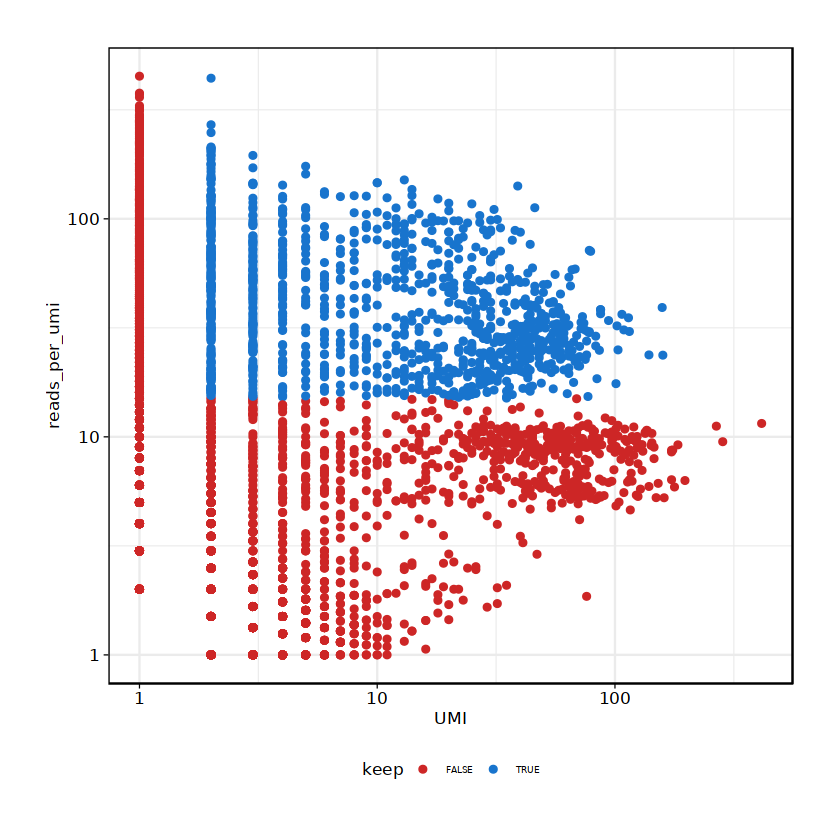

In [61]:
ggplot(ts_data_all[sample(1:nrow(ts_data_all), size = 10000),]
       , aes(y = reads_per_umi, x = UMI, color = keep)) + geom_point() + scale_x_log10() + scale_y_log10()

In [63]:
ts_data_all <- ts_data_all[ts_data_all$keep,]
ts_data_all <- ts_data_all[nchar(ts_data_all$intID) ==10,]
dim(ts_data_all)

[1] 1535847       9

In [64]:
ts_data_all$r1_call <- ifelse(ts_data_all$RNF2 == "None", "RNF2_wt", 
                              ifelse(ts_data_all$RNF2 == "GTCAG", "RNF2_mut", NA))
ts_data_all$r2_call <- ifelse(ts_data_all$HEK3 == "None", "HEK3_wt", 
                              ifelse(ts_data_all$HEK3 == "GTCAG", "HEK3_mut", NA))
ts_data_all$r3_call <- ifelse(ts_data_all$EMX1 == "None", "EMX1_wt", 
                              ifelse(ts_data_all$EMX1 == "GTCAG", "EMX1_mut", NA))
ts_data_all$allele_call <- paste(ts_data_all$r1_call, ts_data_all$r2_call, ts_data_all$r3_call, sep = ";")

In [65]:
ts_data_summary <- ts_data_all %>% group_by(cellBC, intID) %>% 
    summarise(nUMI = sum(UMI), nReads = sum(readCount), propUMI = max(UMI)/sum(UMI)
              , propReads = max(readCount)/sum(readCount)
              , r1_call = r1_call[order(UMI, decreasing = TRUE)][1]
              , r2_call = r2_call[order(UMI, decreasing = TRUE)][1]
              , r3_call = r3_call[order(UMI, decreasing = TRUE)][1]
              , allele_call = allele_call[order(UMI, decreasing = TRUE)][1])

In [ ]:
ts_data_summary$sample <- gsub("_[ACGT]*-1$", "", ts_data_summary$cellBC)

In [76]:
write.table(ts_data_summary, "data/ts_data_summary.txt", sep = "\t", quote = FALSE, row.names = FALSE)

In [77]:
ts_data_summary <- ts_data_summary[ts_data_summary$propReads > 0.9 &
                                   ts_data_summary$propUMI > 0.9,]

In [86]:
ts_cell_summary <- ts_data_summary %>% group_by(cellBC) %>% summarise(nIntBC = length(unique(intID))
                                                                      , nRNF2_mut = length(r1_call[r1_call == "RNF2_mut"])
                                                                     , nHEK3_mut = length(r2_call[r2_call == "HEK3_mut"])
                                                                      , nEMX1_mut = length(r3_call[r3_call == "EMX1_mut"])
                                                                      , nRNF2_wt = length(r1_call[r1_call == "RNF2_wt"])
                                                                     , nHEK3_wt = length(r2_call[r2_call == "HEK3_wt"])
                                                                      , nEMX1_wt = length(r3_call[r3_call == "EMX1_wt"])
                                                                     )
ts_cell_summary$n_mut <- rowSums(ts_cell_summary[,3:5] != 0)

In [87]:
ts_cell_summary <- data.frame(ts_cell_summary)
rownames(ts_cell_summary) <- ts_cell_summary$cellBC
ts_cell_summary <- ts_cell_summary[,2:9]

In [88]:
merge_obj <- AddMetaData(merge_obj, ts_cell_summary)

In [89]:
saveRDS(merge_obj, "data/4T1_B16F10_kinetics.rds")

In [100]:
old_sample_names <- gsub("_cell_identities.csv","", basename(
    list.files(path = paste0("/lab/solexa_weissman/kyost/pe_lineage/230111_B16F10_4T1_CROP_NovaSeq/",
                             "guide_calling_output"), pattern = ".*cell_identities.csv", full.names = TRUE)))
old_sample_names <- setNames(old_sample_names, c('4T1_D10_rep2', '4T1_D14_rep2', '4T1_D14_rep1'
                                                 , '4T1_D14_rep3', '4T1_D14_rep4', '4T1_D21_rep1'
                                                , '4T1_D28_rep1', '4T1_D6_rep1', 'B16F10_D10_rep1'
                                                 , 'B16F10_D14_rep1', 'B16F10_D21_rep1', 'B16F10_D28_rep1'
                                                , 'B16F10_D28_rep2', 'B16F10_D4_rep1', 'B16F10_D6_rep1'))

In [102]:
guide_calls_all <- data.frame(matrix(nrow = 0, ncol = 0))
for (i in list.files(path = paste0("/lab/solexa_weissman/kyost/pe_lineage/230111_B16F10_4T1_CROP_NovaSeq/",
                                   "guide_calling_output"), pattern = ".*cell_identities.csv", full.names = TRUE)) {
    guide_calls <- read.csv(i)
    sample <- suppressMessages(plyr::mapvalues(gsub("_cell_identities.csv","", basename(i))
                                               , from = unname(old_sample_names), to = names(old_sample_names)))
    message(sample)
    guide_calls$cell_barcode <- paste0(sample, "_", guide_calls$cell_barcode)
    guide_calls <- merge(guide_calls, feature_ref_protospacers, all.x = TRUE)
    guide_calls_summary <- data.frame(guide_calls %>% group_by(cell_barcode) %>% 
                                      summarise(guide_identity = paste(guide_identity, collapse = ";")
                                                , guide_call = paste(guide_name, collapse = "|")))
    rownames(guide_calls_summary) <- guide_calls_summary$cell_barcode
    guide_calls_summary <- guide_calls_summary[,2:3]
    guide_calls_all <- rbind(guide_calls_all, guide_calls_summary)
}

4T1_D10_rep2

4T1_D14_rep2

4T1_D14_rep1

4T1_D14_rep3

4T1_D14_rep4

4T1_D21_rep1

4T1_D28_rep1

4T1_D6_rep1

B16F10_D10_rep1

B16F10_D14_rep1

B16F10_D21_rep1

B16F10_D28_rep1

B16F10_D28_rep2

B16F10_D4_rep1

B16F10_D6_rep1



In [106]:
merge_obj <- AddMetaData(merge_obj, metadata = guide_calls_all)

In [ ]:
saveRDS(merge_obj, "data/4T1_B16F10_kinetics.rds")